# Install requirements

In [ ]:
!pip install PyPDF2
!pip install pytesseract
!pip install transformers
!pip install PyMuPDF pillow
!pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 32.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using c

# Import Libaries

In [ ]:
from bs4 import BeautifulSoup
from io import BytesIO
import PyPDF2
from PyPDF2 import PdfReader
import pytesseract
from PIL import Image
import requests
import fitz  # PyMuPDF
import random
import time
import io
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# EDA

**Description:**
1. Reads a CSV file as input
2. ```preprocess``` function removes duplicates and missing values.
3. ```incorrect_url``` function adds https if url doesnt startwith it.
4. ```processed``` function concatenates results of both above function and returns processed dataframe.

In [ ]:

class DataPreprocess:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)

    def display(self):
        print(self.df.head())
        print()
        print(self.df.info())

    # This function gives processed dataframe with correct urls
    def pre_processed(self):
        no_dup = self.df.drop_duplicates()
        corrected_df = no_dup[no_dup['datasheet_link'] != '-']
        corrected_df = corrected_df.dropna()

        # corrected_df = corrected_df[~corrected_df.apply(lambda row: row.astype(str).str.contains('8e9daddd-82b0-4ed4-a656-a8aa011ea6d3').any(), axis=1)]
        corrected_df = corrected_df[corrected_df['datasheet_link'].str.startswith('http')]

        # corrected_df = corrected_df[corrected_df['datasheet_link'].str.endswith('.pdf')]
        corrected_df = corrected_df.reset_index(drop=True)

        return corrected_df

    def incorrect_url(self):
        incorrect_url_df = self.df[~self.df['datasheet_link'].str.startswith('http')]
        incorrect_url_df['datasheet_link'] = 'https:' + incorrect_url_df['datasheet_link']
        return incorrect_url_df

    def processed(self):
        df1 = self.pre_processed()
        df2 = self.incorrect_url()
        return pd.concat([df1, df2], ignore_index=True)

    # def non_pdf(self):
    #     non_pdf_df = self.df[~self.df['datasheet_link'].str.endswith('.pdf')]
    #     return non_pdf_df

    # This function gives dataframe with incorrect urls which needs further preprocessing
    # def need_preprocess(self):
    #     incorrect_http = self.incorrect_url()
        # incorrect_pdf = self.non_pdf()
        # return incorrect_http, incorrect_pdf


In [ ]:
data_processor = DataPreprocess('/content/drive/MyDrive/Parspec/train_data/mle-1-assign-dataset - train_data.csv')
data_processor.display()
preprocessed_data = data_processor.processed()
print('-' * 50)
print("Shape:", preprocessed_data.shape)
print('-' * 50)

                                      datasheet_link target_col
0  https://lfillumination.com/files/specsheets/EF...   lighting
1  https://lfillumination.com/files/specsheets/EF...   lighting
2  https://lfillumination.com/files/specsheets/EF...   lighting
3  https://www.waclighting.com/storage/waclightin...   lighting
4  https://www.acuitybrands.com/api/products/geta...   lighting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   datasheet_link  1895 non-null   object
 1   target_col      1895 non-null   object
dtypes: object(2)
memory usage: 29.7+ KB
None
--------------------------------------------------
Shape: (1262, 2)
--------------------------------------------------


<ipython-input-7-9f7a5a2e5408>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_url_df['datasheet_link'] = 'https:' + incorrect_url_df['datasheet_link']


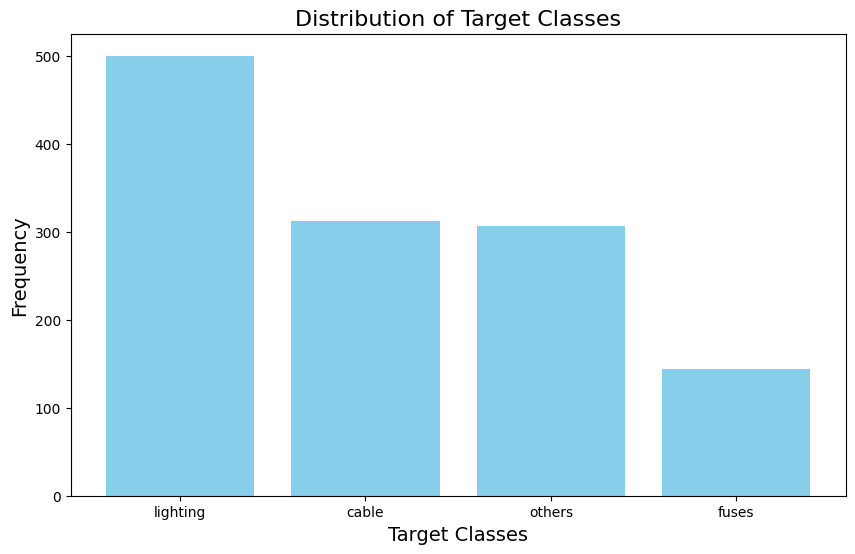

In [ ]:
# Distribution of the target classes
target_class = preprocessed_data['target_col'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(target_class.index, target_class.values, color='skyblue')

plt.title('Distribution of Target Classes', fontsize=16)
plt.xlabel('Target Classes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Extract Data

## Process correct urls (train)

**Description:**
1. ```url_process``` extracts text from the first page of the PDF.
If text extraction fails, it attempts to extract images from the PDF using below functions.
2. ```image_process``` extracts text from image
3. ```extract_images``` extracts images from the first page of the PDF
4. ```extract_text``` uses multiprocessing to process each row of a DataFrame and returns dataframe with additional column "content" with the corresponding text



In [ ]:

class ExtractData:
    def __init__(self, image_dir='images', max_retries=5):
        self.image_dir = image_dir
        self.max_retries = max_retries
        if not os.path.exists(image_dir):
            os.makedirs(image_dir)

    def url_process(self, url): # Extracts text from the PDF
        for attempt in range(self.max_retries):
            try:
                headers = {'User-Agent': 'Mozilla/5.0'}
                response = requests.get(url, headers=headers, timeout=20)
                time.sleep(1)

                if response.status_code == 200:
                    pdf_file = io.BytesIO(response.content)
                    doc = fitz.open(stream=pdf_file, filetype='pdf')
                    text = ""

                    # Extract text from the first page
                    for page_num in range(min(1, len(doc))):
                        page = doc.load_page(page_num)
                        page_text = page.get_text()
                        text += page_text

                    if text.strip():
                        return text, []

                    # Extract images if text extraction fails
                    image_paths = self.extract_images(doc)
                    return text, image_paths
            except Exception as e:
                # print(url)
                print(f"Error extracting text from PDF: {e}")

            sleep_time = 2 * attempt + random.uniform(0, 1)
            time.sleep(sleep_time)

        return None, []

    def image_process(self, image_path): # Extracts text from image

        try:
            image = Image.open(image_path)
            text = pytesseract.image_to_string(image)
            return text
        except Exception as e:
            # print(f"Error extracting text from image: {e}")
            return None

    def extract_images(self, doc):  # Extract images and returns image paths

        image_paths = []
        for page_num in range(min(1, len(doc))):
            page = doc.load_page(page_num)
            image_list = page.get_images(full=True)
            for img_index, img in enumerate(image_list):
                xref = img[0]
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]
                image_ext = base_image["ext"]
                image_filename = f"{self.image_dir}/page_{page_num}_img_{img_index}.{image_ext}"
                with open(image_filename, "wb") as img_file:
                    img_file.write(image_bytes)
                image_paths.append(image_filename)
        return image_paths

    def process_row(self, row):  # process each url from dataframe to extract text.
        url = row['datasheet_link']
        text, image_paths = self.url_process(url)
        if not text:  # If no text was extracted from the PDF, try OCR on images
            text = ""
            for img_path in image_paths:
                img_text = self.image_process(img_path)
                if img_text:
                    text += " " + img_text
        return text.strip()

    def extract_text(self, df): # uses multiprocessing to extract text from url

        df['content'] = ""   # Text will be stored in new column

        with ProcessPoolExecutor() as executor:
            # Create futures
            futures = {executor.submit(self.process_row, row): idx for idx, row in df.iterrows()}
            for future in tqdm(as_completed(futures), total=len(futures), desc='Processing rows'):
                idx = futures[future]
                try:
                    df.at[idx, 'content'] = future.result()
                except Exception as e:
                    print(f"Error processing row {idx}: {e}")
                    df.at[idx, 'content'] = ""

        return df

In [ ]:
extractor = ExtractData()
df6 = extractor.extract_text(preprocessed_data[1000:])

df6.to_csv('/content/drive/MyDrive/Parspec/train_data/df2_1000_last.csv', escapechar='\\', index=False)
# df.to_csv('/content/drive/MyDrive/Parspec/processed_df_200_350.csv', escapechar='\\', index=False)
# df.to_csv('/content/drive/MyDrive/Parspec/processed_df_350_500.csv', escapechar='\\', index=False)
# df.to_csv('/content/drive/MyDrive/Parspec/processed_df_500_last.csv', escapechar='\\', index=False)

<ipython-input-10-1c5041cc5316>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = ""
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Processing rows:   5%|▍         | 12/262 [00:14<03:55,  1.06it/s]

https://www.microsemi.com/document-portal/doc_download/9439-lxmg1627-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9409-lxmg1622-12-01-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9439-lxmg1627-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9409-lxmg1622-12-01-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9439-lxmg1627-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9409-lxmg1622-12-01-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9439-lxmg1627-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_do

Processing rows:   7%|▋         | 18/262 [00:54<11:32,  2.84s/it]

https://www.microsemi.com/document-portal/doc_download/9384-lxmg1617a-05-2x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9388-lxmg1617a-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9384-lxmg1617a-05-2x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9388-lxmg1617a-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9384-lxmg1617a-05-2x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9388-lxmg1617a-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9384-lxmg1617a-05-2x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal

Processing rows:   8%|▊         | 21/262 [01:33<27:47,  6.92s/it]

https://www.microsemi.com/document-portal/doc_download/9381-lxmg1617-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9325-lxm1617054x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9381-lxmg1617-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9325-lxm1617054x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9381-lxmg1617-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9325-lxm1617054x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9381-lxmg1617-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/93

Processing rows:   9%|▉         | 23/262 [02:08<42:51, 10.76s/it]  

https://www.microsemi.com/document-portal/doc_download/9320-lxm1617-05-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9327-lxm1617124x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9320-lxm1617-05-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9327-lxm1617124x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9327-lxm1617124x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9320-lxm1617-05-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9327-lxm1617124x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9320-lxm

Processing rows:  10%|▉         | 25/262 [02:43<49:55, 12.64s/it]  

https://www.microsemi.com/document-portal/doc_download/9356-lxm1624-12-6x-pdf
Error extracting text from PDF: code=7: no objects found


Processing rows:  10%|▉         | 26/262 [02:45<38:13,  9.72s/it]

https://www.microsemi.com/document-portal/doc_download/9367-lxm1643-12-6x-pdfhttps://www.microsemi.com/document-portal/doc_download/9356-lxm1624-12-6x-pdf

Error extracting text from PDF: code=7: no objects foundError extracting text from PDF: code=7: no objects found

https://www.microsemi.com/document-portal/doc_download/9367-lxm1643-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9356-lxm1624-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9367-lxm1643-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9356-lxm1624-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9367-lxm1643-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/

Processing rows:  11%|█         | 28/262 [03:21<48:08, 12.34s/it]  

https://www.microsemi.com/document-portal/doc_download/9341-lxm1621xx-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9329-lxm1618-03-2x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9341-lxm1621xx-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9329-lxm1618-03-2x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9341-lxm1621xx-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9329-lxm1618-03-2x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9341-lxm1621xx-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9329-lxm1618-03-

Processing rows:  11%|█▏        | 30/262 [03:55<51:57, 13.44s/it]  

https://www.microsemi.com/document-portal/doc_download/9350-lxm1623-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9416-lxmg1623-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9350-lxm1623-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9416-lxmg1623-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9350-lxm1623-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9416-lxmg1623-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9350-lxm1623-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_downlo

Processing rows:  12%|█▏        | 32/262 [04:31<54:18, 14.17s/it]  

https://www.microsemi.com/document-portal/doc_download/9407-lxmg1621-xx-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9418-lxmg1624-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9407-lxmg1621-xx-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9418-lxmg1624-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9407-lxmg1621-xx-pdf

Error extracting text from PDF: code=7: no objects foundhttps://www.microsemi.com/document-portal/doc_download/9418-lxmg1624-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9407-lxmg1621-xx-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9418-

Processing rows:  13%|█▎        | 34/262 [05:06<55:46, 14.68s/it]  

https://www.microsemi.com/document-portal/doc_download/9415-lxmg1623-12-4x-pdf
Error extracting text from PDF: code=7: no objects found


Processing rows:  13%|█▎        | 35/262 [05:08<41:13, 10.89s/it]

https://www.microsemi.com/document-portal/doc_download/9415-lxmg1623-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.
Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  14%|█▎        | 36/262 [05:11<31:16,  8.30s/it]

https://www.microsemi.com/document-portal/doc_download/9387-lxmg1617a-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9415-lxmg1623-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9387-lxmg1617a-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9387-lxmg1617a-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9415-lxmg1623-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9387-lxmg1617a-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9415-lxmg1623-12-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/do

Processing rows:  14%|█▍        | 37/262 [05:38<52:43, 14.06s/it]

https://www.microsemi.com/document-portal/doc_download/9402-lxmg1618a-05-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9402-lxmg1618a-05-4x-pdf
Error extracting text from PDF: code=7: no objects found


Processing rows:  15%|█▍        | 38/262 [05:46<45:14, 12.12s/it]

https://www.microsemi.com/document-portal/doc_download/9438-lxmg1627-12-44-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9402-lxmg1618a-05-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9438-lxmg1627-12-44-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9438-lxmg1627-12-44-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9402-lxmg1618a-05-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9438-lxmg1627-12-44-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9402-lxmg1618a-05-4x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc

Processing rows:  15%|█▍        | 39/262 [06:15<1:04:08, 17.26s/it]

https://www.microsemi.com/document-portal/doc_download/9441-lxmg1628-12-6x-pdf
Error extracting text from PDF: code=7: no objects found


Processing rows:  15%|█▌        | 40/262 [06:20<50:41, 13.70s/it]  

https://www.microsemi.com/document-portal/doc_download/9441-lxmg1628-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9433-lxmg1626-12-67-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9441-lxmg1628-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9433-lxmg1626-12-67-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9433-lxmg1626-12-67-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9441-lxmg1628-12-6x-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_download/9433-lxmg1626-12-67-pdf
Error extracting text from PDF: code=7: no objects found
https://www.microsemi.com/document-portal/doc_do

Processing rows:  16%|█▌        | 41/262 [06:49<1:07:20, 18.28s/it]

https://www.microsemi.com/document-portal/doc_download/9436-lxmg1627-05-4x-pdf
Error extracting text from PDF: code=7: no objects found


Processing rows:  16%|█▌        | 42/262 [06:55<53:12, 14.51s/it]  

https://www.microsemi.com/document-portal/doc_download/9436-lxmg1627-05-4x-pdf
Error extracting text from PDF: code=7: no objects found


Processing rows:  18%|█▊        | 47/262 [07:01<12:01,  3.36s/it]

https://www.microsemi.com/document-portal/doc_download/9436-lxmg1627-05-4x-pdf
Error extracting text from PDF: code=7: no objects found


Processing rows:  20%|██        | 53/262 [07:07<04:52,  1.40s/it]

https://www.microsemi.com/document-portal/doc_download/9436-lxmg1627-05-4x-pdf
Error extracting text from PDF: code=7: no objects found


Processing rows:  21%|██        | 54/262 [07:09<04:31,  1.30s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  23%|██▎       | 59/262 [07:14<03:41,  1.09s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https://www.microsemi.com/document-portal/doc_download/9436-lxmg1627-05-4x-pdf
Error extracting text from PDF: code=7: no objects found
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  23%|██▎       | 60/262 [07:25<13:37,  4.05s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  24%|██▎       | 62/262 [07:37<15:51,  4.76s/it]

https:-

Error extracting text from PDF: Invalid URL 'https:-': No host supplied

Processing rows:  24%|██▍       | 63/262 [07:38<12:04,  3.64s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  24%|██▍       | 64/262 [07:47<16:46,  5.08s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  25%|██▍       | 65/262 [08:01<25:14,  7.69s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  25%|██▌       | 66/262 [08:10<26:51,  8.22s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  26%|██▌       | 67/262 [08:22<30:24,  9.35s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  28%|██▊       | 73/262 [08:29<06:30,  2.07s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  28%|██▊       | 74/262 [08:32<06:58,  2.22s/it]

https:-

Processing rows:  29%|██▊       | 75/262 [08:33<05:50,  1.87s/it]


Error extracting text from PDF: Invalid URL 'https:-': No host suppliedhttps:-

Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  29%|██▉       | 77/262 [08:53<16:30,  5.35s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  30%|██▉       | 78/262 [08:56<13:40,  4.46s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  31%|███       | 80/262 [09:16<19:50,  6.54s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  31%|███       | 81/262 [09:17<14:30,  4.81s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  32%|███▏      | 83/262 [09:40<21:45,  7.29s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  32%|███▏      | 84/262 [09:41<15:53,  5.36s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  35%|███▍      | 91/262 [10:06<04:46,  1.68s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  35%|███▌      | 92/262 [10:06<03:47,  1.34s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  38%|███▊      | 100/262 [10:31<03:05,  1.15s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  39%|███▊      | 101/262 [10:32<02:22,  1.13it/s]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  39%|███▉      | 102/262 [10:33<02:30,  1.06it/s]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  39%|███▉      | 103/262 [10:54<18:38,  7.03s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  40%|████      | 105/262 [10:57<10:45,  4.11s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  41%|████      | 107/262 [10:59<06:36,  2.56s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  41%|████      | 108/262 [11:17<18:34,  7.24s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  42%|████▏     | 109/262 [11:21<16:08,  6.33s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  42%|████▏     | 111/262 [11:39<17:40,  7.02s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  44%|████▎     | 114/262 [11:45<08:42,  3.53s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  44%|████▍     | 116/262 [12:04<14:12,  5.84s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  46%|████▌     | 120/262 [12:12<05:57,  2.52s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  47%|████▋     | 123/262 [12:15<03:36,  1.56s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  47%|████▋     | 124/262 [12:27<10:59,  4.78s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-

Error extracting text from PDF: Invalid URL 'https:-': No host suppliedhttps:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  48%|████▊     | 126/262 [12:39<11:19,  5.00s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  48%|████▊     | 127/262 [12:50<14:50,  6.59s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  50%|████▉     | 130/262 [13:04<10:05,  4.59s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  51%|█████     | 134/262 [13:08<04:05,  1.92s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  52%|█████▏    | 135/262 [13:13<05:48,  2.75s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  65%|██████▍   | 169/262 [13:50<00:49,  1.89it/s]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  65%|██████▌   | 171/262 [13:51<00:49,  1.84it/s]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  66%|██████▌   | 172/262 [14:13<06:22,  4.25s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  66%|██████▌   | 173/262 [14:14<05:20,  3.60s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  68%|██████▊   | 177/262 [14:37<05:00,  3.54s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  68%|██████▊   | 178/262 [14:38<03:40,  2.63s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  68%|██████▊   | 179/262 [15:01<11:37,  8.41s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  69%|██████▉   | 181/262 [15:03<06:55,  5.14s/it]

https:-

Processing rows:  69%|██████▉   | 182/262 [15:04<05:31,  4.15s/it]


Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  71%|███████   | 186/262 [15:08<02:26,  1.93s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  73%|███████▎  | 192/262 [15:15<01:23,  1.19s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  74%|███████▎  | 193/262 [15:16<01:19,  1.15s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied
https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows:  76%|███████▌  | 199/262 [15:29<01:29,  1.43s/it]

https:-
Error extracting text from PDF: Invalid URL 'https:-': No host supplied


Processing rows: 100%|██████████| 262/262 [16:06<00:00,  3.69s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Parspec/train_data/df1_200.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Parspec/train_data/df2_200_400.csv")
df3 = pd.read_csv("/content/drive/MyDrive/Parspec/train_data/df2_400_600.csv")
df4 = pd.read_csv("/content/drive/MyDrive/Parspec/train_data/df2_600_800.csv")
df5 = pd.read_csv("/content/drive/MyDrive/Parspec/train_data/df2_800_1000.csv")
df6 = pd.read_csv("/content/drive/MyDrive/Parspec/train_data/df2_1000_last.csv")

final_df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
final_df.to_csv('/content/drive/MyDrive/Parspec/train_data/train_data_df6.csv', escapechar='\\', index=False)

In [ ]:
final_df = pd.read_csv("/content/drive/MyDrive/Parspec/train_data/train_data_df6.csv")
incorrect_urls = final_df[final_df.isna().any(axis=1)]
incorrect_urls.shape

incorrect_urls.to_csv('/content/drive/MyDrive/Parspec/train_data/incorrect_urls.csv', escapechar='\\', index=False)

(208, 3)

## Process incorrect urls (train)

**Description:**
Processes URLs in a CSV file to extract text from images embedded in *PDF viewers*.

1. ```fetch_image_url``` Retrieves page content.
2. ```download_image``` downloads the 2nd page of pdf
3. ```extract_text_from_image``` extracts text from downloaded image
4. ```process_csv_and_download_images``` Loads csv with urls and returns dataframe with new column "content" which has corresponding text


In [ ]:
# # Some pdf urls are of pdf-viewer type.

# def fetch_image_url(page_url, page_number):
#     headers = {
#         "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36",
#         "Accept": "application/pdf",
#         "Accept-Encoding": "none",
#     }
#     try:
#         response = requests.get(page_url, headers=headers, timeout=20)
#         response.raise_for_status()
#     except requests.exceptions.RequestException as e:
#         print(f"Request failed for {page_url}: {e}")
#         return None

#     soup = BeautifulSoup(response.text, 'html.parser')
#     meta_tag = soup.find('meta', property='og:image')

#     if meta_tag and 'content' in meta_tag.attrs:
#         url = meta_tag['content']
#         url = url.replace('1.jpg', f'{page_number}.jpg')
#         return url
#     else:
#         print("'og:image' not found.")
#         return None

# def download_image(image_url, save_path):
#     try:
#         response = requests.get(image_url)
#         response.raise_for_status()  # Raises an error for bad responses
#     except requests.exceptions.RequestException as e:
#         print(f"Failed to download image from {image_url}: {e}")
#         return

#     with open(save_path, 'wb') as file:
#         file.write(response.content)
#     print(f"Image successfully downloaded: {save_path}")

# def extract_text_from_image(image_path):
#     try:
#         img = Image.open(image_path)
#         text = pytesseract.image_to_string(img)
#         return text
#     except Exception as e:
#         print(f"Failed to extract text from {image_path}: {e}")
#         return ""

# def process_csv_and_download_images(csv_path):
#     df = pd.read_csv(csv_path)

#     df['content'] = ""

#     for index, row in tqdm(df.iterrows(), total=len(df)):
#         page_url = row['datasheet_link']

#         image_url = fetch_image_url(page_url, 1)

#         if image_url:
#             save_path = os.path.join('images', f'image_{index}.jpg')
#             os.makedirs(os.path.dirname(save_path), exist_ok=True)
#             download_image(image_url, save_path)

#             extracted_text = extract_text_from_image(save_path)

#             # Add the extracted text to the corresponding row in the DataFrame in content column
#             df.at[index, 'content'] = extracted_text
#         else:
#             print(f"Skipping URL: {page_url} due to errors.\n")

#     return df

# # Usage
# csv_path = '/content/drive/MyDrive/Parspec/train_data/incorrect_urls.csv'
# processed_incorrect_urls = process_csv_and_download_images(csv_path)
# processed_incorrect_urls.to_csv("/content/drive/MyDrive/Parspec/train_data/incorrect_processed_urls.csv", escapechar='\\', index=False)

  0%|          | 1/208 [00:01<03:35,  1.04s/it]

Request failed for https://lfillumination.com/files/specsheets/EF411B.PDF: 404 Client Error: Not Found for url: https://lfillumination.com/files/specsheets/EF411B.PDF
Skipping URL: https://lfillumination.com/files/specsheets/EF411B.PDF due to errors.



  1%|          | 2/208 [00:03<06:55,  2.02s/it]

Request failed for https://www.acuitybrands.com/api/products/getasset/holophane/1649332/4408a251-09be-4b61-813f-177b3ebcf10c/holophane-care222-hldmpc-cylinder-pendant-with-cord.pdf?abl_version=01%2f12%2f2023+16%3a54%3a24&DOC_Type=SPEC_SHEET: 404 Client Error: Not Found for url: https://www.acuitybrands.com/api/products/getasset/holophane/1649332/4408a251-09be-4b61-813f-177b3ebcf10c/holophane-care222-hldmpc-cylinder-pendant-with-cord.pdf?abl_version=01%2F12%2F2023+16%3A54%3A24&DOC_Type=SPEC_SHEET
Skipping URL: https://www.acuitybrands.com/api/products/getasset/holophane/1649332/4408a251-09be-4b61-813f-177b3ebcf10c/holophane-care222-hldmpc-cylinder-pendant-with-cord.pdf?abl_version=01%2f12%2f2023+16%3a54%3a24&DOC_Type=SPEC_SHEET due to errors.



  1%|▏         | 3/208 [00:07<09:39,  2.83s/it]

Request failed for https://beghelliusa.com/wp-content/uploads/2022/05/testa_spec.pdf: 404 Client Error: Not Found for url: https://beghelliusa.com/wp-content/uploads/2023/08/testa_spec.pdf
Skipping URL: https://beghelliusa.com/wp-content/uploads/2022/05/testa_spec.pdf due to errors.



  2%|▏         | 4/208 [00:10<09:38,  2.83s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_3.jpg: [Errno 2] No such file or directory: 'images/image_3.jpg'


  2%|▏         | 5/208 [00:12<09:07,  2.70s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_4.jpg: [Errno 2] No such file or directory: 'images/image_4.jpg'


  3%|▎         | 6/208 [00:15<09:12,  2.73s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_5.jpg: [Errno 2] No such file or directory: 'images/image_5.jpg'


  3%|▎         | 7/208 [00:18<08:57,  2.67s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_6.jpg: [Errno 2] No such file or directory: 'images/image_6.jpg'


  4%|▍         | 8/208 [00:21<09:42,  2.91s/it]

Request failed for https://beghelliusa.com/wp-content/uploads/2022/06/mpl-spec-15-280w_combined.pdf: 404 Client Error: Not Found for url: https://beghelliusa.com/wp-content/uploads/2022/06/mpl-spec-15-280w_combined.pdf
Skipping URL: https://beghelliusa.com/wp-content/uploads/2022/06/mpl-spec-15-280w_combined.pdf due to errors.



  4%|▍         | 9/208 [00:22<07:42,  2.33s/it]

Request failed for https://lithonia.acuitybrands.com/api/products/getasset/lithonia-lighting/47332/28a353c1-2a40-4bec-81c0-2083787604bf/msfl.pdf?abl_version=10%2f04%2f2022+22%3a57%3a52&DOC_Type=SPEC_SHEET: 404 Client Error: Not Found for url: https://lithonia.acuitybrands.com/api/products/getasset/lithonia-lighting/47332/28a353c1-2a40-4bec-81c0-2083787604bf/msfl.pdf?abl_version=10%2F04%2F2022+22%3A57%3A52&DOC_Type=SPEC_SHEET
Skipping URL: https://lithonia.acuitybrands.com/api/products/getasset/lithonia-lighting/47332/28a353c1-2a40-4bec-81c0-2083787604bf/msfl.pdf?abl_version=10%2f04%2f2022+22%3a57%3a52&DOC_Type=SPEC_SHEET due to errors.



  5%|▍         | 10/208 [00:23<05:55,  1.80s/it]

Request failed for https://www.axislighting.com/application/files/1816/6967/0425/Graze_Perfekt-Perimeter-Recessed.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/1816/6967/0425/Graze_Perfekt-Perimeter-Recessed.SPEC.pdf
Skipping URL: https://www.axislighting.com/application/files/1816/6967/0425/Graze_Perfekt-Perimeter-Recessed.SPEC.pdf due to errors.



  5%|▌         | 11/208 [00:26<06:58,  2.12s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_10.jpg: [Errno 2] No such file or directory: 'images/image_10.jpg'


  6%|▌         | 12/208 [00:27<06:29,  1.99s/it]

Request failed for https://www.contechlighting.com/en/docs/CLB_0720.pdf: 404 Client Error: Not Found for url: https://contechlighting.com/en/docs/CLB_0720.pdf
Skipping URL: https://www.contechlighting.com/en/docs/CLB_0720.pdf due to errors.



  6%|▋         | 13/208 [00:28<05:00,  1.54s/it]

Request failed for https://www.lsicorp.com/wp-content/uploads/2020/05/augustaaud-aupleddatasheet.pdf: 404 Client Error: Not Found for url: https://www.lsicorp.com/wp-content/uploads/2020/05/augustaaud-aupleddatasheet.pdf
Skipping URL: https://www.lsicorp.com/wp-content/uploads/2020/05/augustaaud-aupleddatasheet.pdf due to errors.



  7%|▋         | 14/208 [00:28<03:52,  1.20s/it]

Request failed for https://www.lsicorp.com/wp-content/uploads/documents/products/constitution-xcn4-specsheet.pdf: 404 Client Error: Not Found for url: https://www.lsicorp.com/wp-content/uploads/documents/products/constitution-xcn4-specsheet.pdf
Skipping URL: https://www.lsicorp.com/wp-content/uploads/documents/products/constitution-xcn4-specsheet.pdf due to errors.



  7%|▋         | 15/208 [00:30<03:56,  1.22s/it]

Request failed for https://insightlighting.com/download/scope-large-pendant-color-changing-specification-sheet/: 500 Server Error: Internal Server Error for url: https://insightlighting.com/download/scope-large-pendant-color-changing-specification-sheet/
Skipping URL: https://insightlighting.com/download/scope-large-pendant-color-changing-specification-sheet/ due to errors.



  8%|▊         | 16/208 [00:30<03:29,  1.09s/it]

Request failed for https://insightlighting.com/download/pex-direct-view-color-changing-specification-sheets/: 500 Server Error: Internal Server Error for url: https://insightlighting.com/download/pex-direct-view-color-changing-specification-sheets/
Skipping URL: https://insightlighting.com/download/pex-direct-view-color-changing-specification-sheets/ due to errors.



  8%|▊         | 17/208 [00:33<05:13,  1.64s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_16.jpg: [Errno 2] No such file or directory: 'images/image_16.jpg'


  9%|▊         | 18/208 [00:34<04:00,  1.27s/it]

Request failed for https://www.axislighting.com/application/files/1216/7786/1717/EDGE2-Wall.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/1216/7786/1717/EDGE2-Wall.SPEC.pdf
Skipping URL: https://www.axislighting.com/application/files/1216/7786/1717/EDGE2-Wall.SPEC.pdf due to errors.



  9%|▉         | 19/208 [00:36<04:40,  1.48s/it]

Request failed for https://www.contechlighting.com/en/docs/AW_SERIES_2022.pdf: 404 Client Error: Not Found for url: https://contechlighting.com/en/docs/AW_SERIES_2022.pdf
Skipping URL: https://www.contechlighting.com/en/docs/AW_SERIES_2022.pdf due to errors.



 10%|▉         | 20/208 [00:38<05:54,  1.89s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_19.jpg: [Errno 2] No such file or directory: 'images/image_19.jpg'


 10%|█         | 21/208 [00:47<11:48,  3.79s/it]

'og:image' not found.
Skipping URL: https://noralighting.com/wp-content/uploads/2021/02/NELOCAC_16in_spec.pdf due to errors.



 11%|█         | 22/208 [00:48<09:26,  3.05s/it]

Request failed for https://www.intenselighting.com/en/docs/IL_MXG2PSD_WD.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2PSD_WD.pdf
Skipping URL: https://www.intenselighting.com/en/docs/IL_MXG2PSD_WD.pdf due to errors.



 11%|█         | 23/208 [00:50<08:35,  2.79s/it]

Request failed for https://www.intenselighting.com/en/docs/IL_MXG2PSW.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2PSW.pdf
Skipping URL: https://www.intenselighting.com/en/docs/IL_MXG2PSW.pdf due to errors.



 12%|█▏        | 24/208 [00:57<12:33,  4.09s/it]

'og:image' not found.
Skipping URL: https://noralighting.com/wp-content/uploads/2018/11/NRLM_spec.pdf due to errors.



 12%|█▏        | 25/208 [00:58<09:29,  3.11s/it]

Request failed for https://insightlighting.com/download/structure-mini-direct-white-light-spec-sheet/: 500 Server Error: Internal Server Error for url: https://insightlighting.com/download/structure-mini-direct-white-light-spec-sheet/
Skipping URL: https://insightlighting.com/download/structure-mini-direct-white-light-spec-sheet/ due to errors.



 12%|█▎        | 26/208 [01:16<22:30,  7.42s/it]

'og:image' not found.
Skipping URL: https://noralighting.com/wp-content/uploads/2020/08/NPDBL_spec.pdf due to errors.



 13%|█▎        | 27/208 [01:17<17:03,  5.66s/it]

Request failed for https://www.intenselighting.com/en/docs/IL_MXG2PSW_WD.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2PSW_WD.pdf
Skipping URL: https://www.intenselighting.com/en/docs/IL_MXG2PSW_WD.pdf due to errors.



 13%|█▎        | 28/208 [01:18<12:23,  4.13s/it]

Request failed for https://www.intenselighting.com/en/docs/IL_SC8DRREM.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_SC8DRREM.pdf
Skipping URL: https://www.intenselighting.com/en/docs/IL_SC8DRREM.pdf due to errors.



 14%|█▍        | 29/208 [01:50<37:46, 12.66s/it]

'og:image' not found.
Skipping URL: https://noralighting.com/wp-content/uploads/2022/01/NLUD_spec.pdf due to errors.



 14%|█▍        | 30/208 [01:51<27:12,  9.17s/it]

Request failed for https://insightlighting.com/download/scope-mini-surface-color-changing-specification-sheet/: 500 Server Error: Internal Server Error for url: https://insightlighting.com/download/scope-mini-surface-color-changing-specification-sheet/
Skipping URL: https://insightlighting.com/download/scope-mini-surface-color-changing-specification-sheet/ due to errors.



 15%|█▍        | 31/208 [01:52<19:45,  6.70s/it]

Request failed for https://juno.acuitybrands.com/api/products/getasset/juno/1777018/0517f67e-33eb-4973-a114-1b2563aaa4b0/jfx.pdf?abl_version=03%2f14%2f2023+18%3a11%3a50&DOC_Type=SPEC_SHEET: 404 Client Error: Not Found for url: https://juno.acuitybrands.com/api/products/getasset/juno/1777018/0517f67e-33eb-4973-a114-1b2563aaa4b0/jfx.pdf?abl_version=03%2F14%2F2023+18%3A11%3A50&DOC_Type=SPEC_SHEET
Skipping URL: https://juno.acuitybrands.com/api/products/getasset/juno/1777018/0517f67e-33eb-4973-a114-1b2563aaa4b0/jfx.pdf?abl_version=03%2f14%2f2023+18%3a11%3a50&DOC_Type=SPEC_SHEET due to errors.



 15%|█▌        | 32/208 [01:56<17:00,  5.80s/it]

Request failed for https://www.kelvix.com/product/signwave-3/spec-sheet/: 404 Client Error: Not Found for url: https://www.kelvix.com/product/signwave-3/spec-sheet/
Skipping URL: https://www.kelvix.com/product/signwave-3/spec-sheet/ due to errors.



 16%|█▌        | 33/208 [02:00<15:09,  5.20s/it]

Request failed for https://www.kelvix.com/product/brett-502/spec-sheet/: 404 Client Error: Not Found for url: https://www.kelvix.com/product/brett-502/spec-sheet/
Skipping URL: https://www.kelvix.com/product/brett-502/spec-sheet/ due to errors.



 16%|█▋        | 34/208 [02:02<12:42,  4.38s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD_EXT_VERS09.pdf?d=8292022114811: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_EXT_VERS09.pdf?d=8292022114811
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD_EXT_VERS09.pdf?d=8292022114811 due to errors.



 17%|█▋        | 35/208 [02:04<10:50,  3.76s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD_EXT_VERS08.pdf?d=88202230058: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_EXT_VERS08.pdf?d=88202230058
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD_EXT_VERS08.pdf?d=88202230058 due to errors.



 17%|█▋        | 36/208 [02:07<09:30,  3.32s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-WURM-RGBW.pdf?d=34202282606: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-WURM-RGBW.pdf?d=34202282606
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-WURM-RGBW.pdf?d=34202282606 due to errors.



 18%|█▊        | 37/208 [02:09<08:35,  3.01s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-KURV-BK-SC.pdf?d=5202022124454: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-KURV-BK-SC.pdf?d=5202022124454
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-KURV-BK-SC.pdf?d=5202022124454 due to errors.



 18%|█▊        | 38/208 [02:10<07:08,  2.52s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_EMBD-FLAT.pdf?d=125202312226: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_EMBD-FLAT.pdf?d=125202312226
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_EMBD-FLAT.pdf?d=125202312226 due to errors.



 19%|█▉        | 39/208 [02:13<07:02,  2.50s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ATOM-FLAT.pdf?d=8172021104924: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_ATOM-FLAT.pdf?d=8172021104924
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ATOM-FLAT.pdf?d=8172021104924 due to errors.



 19%|█▉        | 40/208 [02:15<06:50,  2.44s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ALTA-FLAT.pdf?d=331202211843: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_ALTA-FLAT.pdf?d=331202211843
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ALTA-FLAT.pdf?d=331202211843 due to errors.



 20%|█▉        | 41/208 [02:18<06:42,  2.41s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ARKA-FLAT.pdf?d=524202220601: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_ARKA-FLAT.pdf?d=524202220601
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ARKA-FLAT.pdf?d=524202220601 due to errors.



 20%|██        | 42/208 [02:20<06:30,  2.35s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_THIN.pdf?d=1220202281306: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_THIN.pdf?d=1220202281306
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_THIN.pdf?d=1220202281306 due to errors.



 21%|██        | 43/208 [02:22<06:27,  2.35s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_TORQ-FLAT.pdf?d=524202221453: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_TORQ-FLAT.pdf?d=524202221453
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_TORQ-FLAT.pdf?d=524202221453 due to errors.



 21%|██        | 44/208 [02:24<06:24,  2.34s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-NEXUS-SW.pdf?d=816202150937: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-NEXUS-SW.pdf?d=816202150937
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-NEXUS-SW.pdf?d=816202150937 due to errors.



 22%|██▏       | 45/208 [02:27<06:18,  2.32s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-LUME-01-SC.pdf?d=1122202192218: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-LUME-01-SC.pdf?d=1122202192218
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-LUME-01-SC.pdf?d=1122202192218 due to errors.



 22%|██▏       | 46/208 [02:29<06:13,  2.31s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-RGB.pdf?d=119202211904: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-RGB.pdf?d=119202211904
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-RGB.pdf?d=119202211904 due to errors.



 23%|██▎       | 47/208 [02:31<06:16,  2.34s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-WALA-SW.pdf?d=816202151258: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-WALA-SW.pdf?d=816202151258
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-WALA-SW.pdf?d=816202151258 due to errors.



 23%|██▎       | 48/208 [02:34<06:14,  2.34s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-SW.pdf?d=119202211634: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-SW.pdf?d=119202211634
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-SW.pdf?d=119202211634 due to errors.



 24%|██▎       | 49/208 [02:36<06:11,  2.34s/it]

Request failed for https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ZALA-SC.pdf?d=4222022123202: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-ZALA-SC.pdf?d=4222022123202
Skipping URL: https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ZALA-SC.pdf?d=4222022123202 due to errors.



 24%|██▍       | 50/208 [02:39<06:35,  2.51s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_49.jpg: [Errno 2] No such file or directory: 'images/image_49.jpg'


 25%|██▍       | 51/208 [02:40<05:46,  2.21s/it]

Request failed for https://www.intenselighting.com/en/docs/IL_MXG2ASTL_BEAM-Adjustable.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2ASTL_BEAM-Adjustable.pdf
Skipping URL: https://www.intenselighting.com/en/docs/IL_MXG2ASTL_BEAM-Adjustable.pdf due to errors.



 25%|██▌       | 52/208 [02:42<05:13,  2.01s/it]

Request failed for https://www.intenselighting.com/en/docs/IL_MXG2DSTL_BEAM-Downlight.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2DSTL_BEAM-Downlight.pdf
Skipping URL: https://www.intenselighting.com/en/docs/IL_MXG2DSTL_BEAM-Downlight.pdf due to errors.



 25%|██▌       | 53/208 [02:42<03:57,  1.53s/it]

Request failed for https://www.axislighting.com/application/files/3116/7778/0070/Stencil-Flex-TDHDP.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/3116/7778/0070/Stencil-Flex-TDHDP.SPEC.pdf
Skipping URL: https://www.axislighting.com/application/files/3116/7778/0070/Stencil-Flex-TDHDP.SPEC.pdf due to errors.



 26%|██▌       | 54/208 [02:43<03:02,  1.19s/it]

Request failed for https://www.axislighting.com/application/files/1016/6491/5004/B2SQD.LED.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/1016/6491/5004/B2SQD.LED.SPEC.pdf
Skipping URL: https://www.axislighting.com/application/files/1016/6491/5004/B2SQD.LED.SPEC.pdf due to errors.



 26%|██▋       | 55/208 [02:43<02:25,  1.05it/s]

Request failed for https://www.axislighting.com/application/files/8516/5712/4018/Stencil-Pendant-Forms-Combined.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/8516/5712/4018/Stencil-Pendant-Forms-Combined.SPEC.pdf
Skipping URL: https://www.axislighting.com/application/files/8516/5712/4018/Stencil-Pendant-Forms-Combined.SPEC.pdf due to errors.



 27%|██▋       | 56/208 [02:44<02:03,  1.23it/s]

Request failed for https://www.waclighting.com/product/strut-56/?download=specs2&1676620206: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-56/?download=specs2&1676620206
Skipping URL: https://www.waclighting.com/product/strut-56/?download=specs2&1676620206 due to errors.



 27%|██▋       | 57/208 [02:44<01:48,  1.40it/s]

Request failed for https://www.waclighting.com/product/strut-57/?download=specs2&1676620195: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-57/?download=specs2&1676620195
Skipping URL: https://www.waclighting.com/product/strut-57/?download=specs2&1676620195 due to errors.



 28%|██▊       | 58/208 [02:45<01:36,  1.55it/s]

Request failed for https://www.waclighting.com/product/strut-55/?download=specs2&1676620218: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-55/?download=specs2&1676620218
Skipping URL: https://www.waclighting.com/product/strut-55/?download=specs2&1676620218 due to errors.



 28%|██▊       | 59/208 [02:45<01:34,  1.57it/s]

Request failed for https://www.waclighting.com/product/strut-54/?download=specs2&1676620230: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-54/?download=specs2&1676620230
Skipping URL: https://www.waclighting.com/product/strut-54/?download=specs2&1676620230 due to errors.



 29%|██▉       | 60/208 [02:46<01:28,  1.67it/s]

Request failed for https://www.waclighting.com/product/strut-58/?download=specs2&1676620183: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-58/?download=specs2&1676620183
Skipping URL: https://www.waclighting.com/product/strut-58/?download=specs2&1676620183 due to errors.



 29%|██▉       | 61/208 [02:49<03:19,  1.36s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_60.jpg: [Errno 2] No such file or directory: 'images/image_60.jpg'


 30%|██▉       | 62/208 [02:51<04:10,  1.71s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_61.jpg: [Errno 2] No such file or directory: 'images/image_61.jpg'


 30%|███       | 63/208 [02:53<04:15,  1.76s/it]

'og:image' not found.
Skipping URL: https://visionairelighting.com/wp-admin/admin-ajax.php?action=outofthebox-download&OutoftheBoxpath=%2F%28a%29%20spec%20sheets%2Farchitectural-lso-l-pt-ar-06_13_2022.pdf&lastpath=%2F%28A%29%20Spec%20Sheets&account_id=dbid:AAAv4IFt3vNayFsFHo-CtHO5R6_ugyP5md8&listtoken=6f411dd52d40dbe2a89951c6b1f36d96 due to errors.



 31%|███       | 64/208 [02:54<03:45,  1.57s/it]

'og:image' not found.
Skipping URL: https://visionairelighting.com/wp-admin/admin-ajax.php?action=outofthebox-download&OutoftheBoxpath=%2F%28a%29%20spec%20sheets%2Farchitectural-pre-2-m-sl-03-01-23.pdf&lastpath=%2F%28A%29%20Spec%20Sheets&account_id=dbid:AAAv4IFt3vNayFsFHo-CtHO5R6_ugyP5md8&listtoken=384c466c77af84702b1390f2a48aa8e2 due to errors.



 31%|███▏      | 65/208 [02:56<03:24,  1.43s/it]

'og:image' not found.
Skipping URL: https://visionairelighting.com/wp-admin/admin-ajax.php?action=outofthebox-download&OutoftheBoxpath=%2F%28a%29%20spec%20sheets%2Farchitectural-pre-2-l-sl-06_13_2022%20%281%29.pdf&lastpath=%2F%28A%29%20Spec%20Sheets&account_id=dbid:AAAv4IFt3vNayFsFHo-CtHO5R6_ugyP5md8&listtoken=19d870dad535290bcc1c47960a50324d due to errors.



 32%|███▏      | 66/208 [02:57<03:09,  1.33s/it]

'og:image' not found.
Skipping URL: https://visionairelighting.com/wp-admin/admin-ajax.php?action=outofthebox-download&OutoftheBoxpath=%2F%28a%29%20spec%20sheets%2Fwall_ceiling-pga-08_29_2022.pdf&lastpath=%2F%28A%29%20Spec%20Sheets&account_id=dbid:AAAv4IFt3vNayFsFHo-CtHO5R6_ugyP5md8&listtoken=b6f2059b1b3db0b191e47b412e9de134 due to errors.



 32%|███▏      | 67/208 [02:58<02:58,  1.27s/it]

'og:image' not found.
Skipping URL: https://visionairelighting.com/wp-admin/admin-ajax.php?action=outofthebox-download&OutoftheBoxpath=%2F%28a%29%20spec%20sheets%2Froadway-rlx-3-ar-08_30_2022.pdf&lastpath=%2F%28A%29%20Spec%20Sheets&account_id=dbid:AAAv4IFt3vNayFsFHo-CtHO5R6_ugyP5md8&listtoken=a26871256e1e30c90b4ad84af9bef378 due to errors.



 33%|███▎      | 68/208 [02:58<02:20,  1.00s/it]

Request failed for https://www.axislighting.com/application/files/1016/7811/8258/B6R.ASY.LED-B3.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/1016/7811/8258/B6R.ASY.LED-B3.SPEC.pdf
Skipping URL: https://www.axislighting.com/application/files/1016/7811/8258/B6R.ASY.LED-B3.SPEC.pdf due to errors.



 33%|███▎      | 69/208 [03:01<03:32,  1.53s/it]

Failed to download image from /-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png: Invalid URL '/-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png': No scheme supplied. Perhaps you meant https:///-/media/abl/acuitybrands/images/social-logos/ab-green-logo.png?
Failed to extract text from images/image_68.jpg: [Errno 2] No such file or directory: 'images/image_68.jpg'


 34%|███▎      | 70/208 [03:16<12:52,  5.60s/it]

'og:image' not found.
Skipping URL: https://noralighting.com/wp-content/uploads/2022/06/NPDBLSW_spec.pdf due to errors.



 34%|███▍      | 71/208 [03:36<22:48,  9.99s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-0603fa-fast-acting-chip-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-0603fa-fast-acting-chip-surface-mount-fuse-data-sheet.pdf due to errors.



 35%|███▍      | 72/208 [03:38<16:47,  7.41s/it]

'og:image' not found.
Skipping URL: https://www.bourns.com/pdfs/SF1206F.pdf due to errors.



 35%|███▌      | 73/208 [03:58<25:14, 11.22s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-gma-time-delay-glass-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-gma-time-delay-glass-tube-fuses-data-sheet.pdf due to errors.



 36%|███▌      | 74/208 [04:18<30:57, 13.86s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-agc-fast-acting-glass-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-agc-fast-acting-glass-tube-fuses-data-sheet.pdf due to errors.



 36%|███▌      | 75/208 [04:38<35:13, 15.89s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216ff-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216ff-surface-mount-fuse-data-sheet.pdf due to errors.



 37%|███▋      | 76/208 [04:59<37:49, 17.19s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-cb61f-surface-mount-brick-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-cb61f-surface-mount-brick-fuses-data-sheet.pdf due to errors.



 37%|███▋      | 77/208 [05:19<39:42, 18.18s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf due to errors.



 38%|███▊      | 78/208 [05:39<40:45, 18.81s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-s505h-vac-time-delay-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-s505h-vac-time-delay-fuses-data-sheet.pdf due to errors.



 38%|███▊      | 79/208 [06:00<41:22, 19.24s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-mda-time-delay-ceramic-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-mda-time-delay-ceramic-tube-fuses-data-sheet.pdf due to errors.



 38%|███▊      | 80/208 [06:20<41:41, 19.54s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216td-time-delay-chip-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216td-time-delay-chip-surface-mount-fuse-data-sheet.pdf due to errors.



 39%|███▉      | 81/208 [06:40<41:40, 19.69s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-pc-tron-subminiature-radial-leaded-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-pc-tron-subminiature-radial-leaded-fuses-data-sheet.pdf due to errors.



 39%|███▉      | 82/208 [07:00<41:48, 19.91s/it]

Request failed for https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/product-aid/eaton-1025hc-fuse-product-aid.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
Skipping URL: https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/product-aid/eaton-1025hc-fuse-product-aid.pdf due to errors.



 40%|███▉      | 83/208 [07:03<30:28, 14.63s/it]

Image successfully downloaded: images/image_82.jpg
Failed to extract text from images/image_82.jpg: tesseract is not installed or it's not in your PATH. See README file for more information.


 40%|████      | 84/208 [07:08<24:13, 11.72s/it]

Image successfully downloaded: images/image_83.jpg
Failed to extract text from images/image_83.jpg: tesseract is not installed or it's not in your PATH. See README file for more information.


 41%|████      | 85/208 [07:13<19:51,  9.69s/it]

Request failed for https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-300.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-300-datasheet.pdf
Skipping URL: https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-300.pdf due to errors.



 41%|████▏     | 86/208 [07:14<14:26,  7.10s/it]

Request failed for https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A5314&DocType=Customer+Drawing&DocLang=English: 500 Server Error: Internal Server Error for url: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A5314&DocType=Customer+Drawing&DocLang=English
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A5314&DocType=Customer+Drawing&DocLang=English due to errors.



 42%|████▏     | 87/208 [07:16<11:13,  5.56s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=0024A0024&DocType=Customer+Drawing&DocLang=English due to errors.



 42%|████▏     | 88/208 [07:17<08:24,  4.21s/it]

Request failed for https://literature.hubersuhner.com/Technologies/Radiofrequency/MicrowavecabelesEN/?gotofirstsearchresult=MINIBEND%20R-2.5&page=1: 404 Client Error: Not Found for url: https://literature.hubersuhner.com/Technologies/Radiofrequency/MicrowavecabelesEN/?gotofirstsearchresult=MINIBEND%20R-2.5&page=1
Skipping URL: https://literature.hubersuhner.com/Technologies/Radiofrequency/MicrowavecabelesEN/?gotofirstsearchresult=MINIBEND%20R-2.5&page=1 due to errors.



 43%|████▎     | 89/208 [07:19<07:22,  3.72s/it]

'og:image' not found.
Skipping URL: https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9174/ due to errors.



 43%|████▎     | 90/208 [07:22<06:46,  3.45s/it]

'og:image' not found.
Skipping URL: https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9316/ due to errors.



 44%|████▍     | 91/208 [07:24<06:03,  3.11s/it]

'og:image' not found.
Skipping URL: https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9178b/ due to errors.



 44%|████▍     | 92/208 [07:25<04:33,  2.36s/it]

Request failed for https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A1317&DocType=Customer+Drawing&DocLang=English&PartCntxt=440063-007: 500 Server Error: Internal Server Error for url: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A1317&DocType=Customer+Drawing&DocLang=English&PartCntxt=440063-007
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A1317&DocType=Customer+Drawing&DocLang=English&PartCntxt=440063-007 due to errors.



 45%|████▍     | 93/208 [07:27<04:27,  2.33s/it]

'og:image' not found.
Skipping URL: https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9888c/ due to errors.



 45%|████▌     | 94/208 [07:30<04:26,  2.34s/it]

'og:image' not found.
Skipping URL: https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9058c/ due to errors.



 46%|████▌     | 95/208 [07:32<04:26,  2.36s/it]

'og:image' not found.
Skipping URL: https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9213/ due to errors.



 46%|████▌     | 96/208 [07:34<04:22,  2.35s/it]

'og:image' not found.
Skipping URL: https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9008/ due to errors.



 47%|████▋     | 97/208 [07:39<05:28,  2.96s/it]

Request failed for https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-500.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-500-datasheet.pdf
Skipping URL: https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-500.pdf due to errors.



 47%|████▋     | 98/208 [07:40<04:45,  2.59s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=2524E0114&DocType=Customer+Drawing&DocLang=English due to errors.



 48%|████▊     | 99/208 [07:41<03:34,  1.96s/it]

Request failed for https://www.molex.com/molex/custom-cable-creator/digikey/: Exceeded 30 redirects.
Skipping URL: https://www.molex.com/molex/custom-cable-creator/digikey/ due to errors.



 48%|████▊     | 100/208 [07:45<04:46,  2.65s/it]

Request failed for https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-LW195.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-lw195-datasheet-1.pdf
Skipping URL: https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-LW195.pdf due to errors.



 49%|████▊     | 101/208 [07:47<04:03,  2.28s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7530A5314&DocType=Customer+Drawing&DocLang=English due to errors.



 49%|████▉     | 102/208 [07:48<03:27,  1.96s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7524A1314&DocType=Customer+Drawing&DocLang=English due to errors.



 50%|████▉     | 103/208 [07:49<03:03,  1.75s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=5026A1137&DocType=Customer+Drawing&DocLang=English due to errors.



 50%|█████     | 104/208 [07:50<02:49,  1.63s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7530A1314&DocType=Customer+Drawing&DocLang=English due to errors.



 50%|█████     | 105/208 [07:52<02:58,  1.74s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=5018D3311&DocType=Customer+Drawing&DocLang=English due to errors.



 51%|█████     | 106/208 [07:53<02:26,  1.44s/it]

Request failed for https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=5022A1311&DocType=Customer+Drawing&DocLang=English: 500 Server Error: Internal Server Error for url: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=5022A1311&DocType=Customer+Drawing&DocLang=English
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=5022A1311&DocType=Customer+Drawing&DocLang=English due to errors.



 51%|█████▏    | 107/208 [07:55<02:41,  1.60s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=5024A3314&DocType=Customer+Drawing&DocLang=English due to errors.



 52%|█████▏    | 108/208 [07:57<02:36,  1.56s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=10602&DocType=Customer+Drawing&DocLang=English due to errors.



 52%|█████▏    | 109/208 [07:58<02:21,  1.43s/it]

'og:image' not found.
Skipping URL: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=2022E0421&DocType=Customer+Drawing&DocLang=English&PartCntxt=CY6750-000 due to errors.



 53%|█████▎    | 110/208 [07:59<02:14,  1.38s/it]

Request failed for https://www.adels-contact.com/pdf351101.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351101.pdf
Skipping URL: https://www.adels-contact.com/pdf351101.pdf due to errors.



 53%|█████▎    | 111/208 [07:59<01:48,  1.12s/it]

Request failed for https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en: 500 Server Error:  for url: https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en
Skipping URL: https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en due to errors.



 54%|█████▍    | 112/208 [08:00<01:39,  1.04s/it]

Request failed for https://www.adels-contact.com/pdf351102.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351102.pdf
Skipping URL: https://www.adels-contact.com/pdf351102.pdf due to errors.



 55%|█████▌    | 115/208 [08:01<00:53,  1.75it/s]

Request failed for https://www.adels-contact.com/pdf151585.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151585.pdf
Skipping URL: https://www.adels-contact.com/pdf151585.pdf due to errors.

Request failed for https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bwb_rotaconnect_rotatable_btb.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bwb_rotaconnect_rotatable_btb.pdf
Skipping URL: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bwb_rotaconnect_rotatable_btb.pdf due to errors.

Request failed for https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/028-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/028-000&lang=en
Skipping URL: https://www.wago.com/global/products/datasheets/Datasheet.pdf?pr

 56%|█████▌    | 116/208 [08:02<00:59,  1.55it/s]

Request failed for https://www.adels-contact.com/pdf151582.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151582.pdf
Skipping URL: https://www.adels-contact.com/pdf151582.pdf due to errors.



 56%|█████▋    | 117/208 [08:03<01:03,  1.43it/s]

Request failed for https://www.adels-contact.com/pdf151183.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151183.pdf
Skipping URL: https://www.adels-contact.com/pdf151183.pdf due to errors.



 57%|█████▋    | 118/208 [08:04<01:06,  1.34it/s]

Request failed for https://www.adels-contact.com/pdf151485.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151485.pdf
Skipping URL: https://www.adels-contact.com/pdf151485.pdf due to errors.



 57%|█████▋    | 119/208 [08:05<01:08,  1.29it/s]

Request failed for https://www.adels-contact.com/pdf151465.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151465.pdf
Skipping URL: https://www.adels-contact.com/pdf151465.pdf due to errors.

Request failed for https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-fls-sr40-01.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-fls-sr40-01.pdf
Skipping URL: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-fls-sr40-01.pdf due to errors.

Request failed for https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2065-133&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2065-133&lang=en
Skipping URL: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2065-133&lang=en due to errors.



 59%|█████▊    | 122/208 [08:06<00:45,  1.91it/s]

Request failed for https://www.adels-contact.com/pdf351901.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351901.pdf
Skipping URL: https://www.adels-contact.com/pdf351901.pdf due to errors.

Request failed for https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-901/021-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-901/021-000&lang=en
Skipping URL: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-901/021-000&lang=en due to errors.

Request failed for https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/030-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/030-000&lang=en
Skipping URL: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/030-000&lang=en due to errors.



 60%|██████    | 125/208 [08:07<00:35,  2.34it/s]

Request failed for https://www.adels-contact.com/pdf351401.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351401.pdf
Skipping URL: https://www.adels-contact.com/pdf351401.pdf due to errors.



 61%|██████    | 126/208 [08:08<00:41,  1.98it/s]

Request failed for https://www.adels-contact.com/pdf151482.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151482.pdf
Skipping URL: https://www.adels-contact.com/pdf151482.pdf due to errors.

Request failed for https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-902/021-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-902/021-000&lang=en
Skipping URL: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-902/021-000&lang=en due to errors.



 62%|██████▏   | 128/208 [08:08<00:32,  2.49it/s]

Request failed for https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s21-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s21-xx.pdf
Skipping URL: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s21-xx.pdf due to errors.



 62%|██████▏   | 129/208 [08:09<00:38,  2.05it/s]

Request failed for https://www.adels-contact.com/pdf11630.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf11630.pdf
Skipping URL: https://www.adels-contact.com/pdf11630.pdf due to errors.

Request failed for https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p21-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p21-xx.pdf
Skipping URL: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p21-xx.pdf due to errors.

Request failed for https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p23-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p23-xx.pdf
Skipping URL: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p23-xx.pdf due to errors.



 63%|██████▎   | 132/208 [08:10<00:30,  2.47it/s]

Request failed for https://www.adels-contact.com/pdf351402.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351402.pdf
Skipping URL: https://www.adels-contact.com/pdf351402.pdf due to errors.

Request failed for https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-903/021-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-903/021-000&lang=en
Skipping URL: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-903/021-000&lang=en due to errors.



 64%|██████▍   | 134/208 [08:11<00:30,  2.41it/s]

Request failed for https://www.adels-contact.com/pdf151583.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151583.pdf
Skipping URL: https://www.adels-contact.com/pdf151583.pdf due to errors.

Request failed for https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p22-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p22-xx.pdf
Skipping URL: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p22-xx.pdf due to errors.

Request failed for https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s23-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s23-xx.pdf
Skipping URL: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s23-xx.pdf due to errors.



 66%|██████▌   | 137/208 [08:13<00:41,  1.71it/s]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9439-lxmg1627-12-4x-pdf due to errors.



 66%|██████▋   | 138/208 [08:15<01:00,  1.16it/s]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9409-lxmg1622-12-01-pdf due to errors.



 67%|██████▋   | 139/208 [08:18<01:17,  1.13s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9384-lxmg1617a-05-2x-pdf due to errors.



 67%|██████▋   | 140/208 [08:20<01:34,  1.38s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9388-lxmg1617a-12-6x-pdf due to errors.



 68%|██████▊   | 141/208 [08:22<01:43,  1.55s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9381-lxmg1617-12-4x-pdf due to errors.



 68%|██████▊   | 142/208 [08:25<01:54,  1.74s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9325-lxm1617054x-pdf due to errors.



 69%|██████▉   | 143/208 [08:27<01:59,  1.84s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9320-lxm1617-05-6x-pdf due to errors.



 69%|██████▉   | 144/208 [08:29<02:11,  2.06s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9327-lxm1617124x-pdf due to errors.



 70%|██████▉   | 145/208 [08:31<02:10,  2.07s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9356-lxm1624-12-6x-pdf due to errors.



 70%|███████   | 146/208 [08:34<02:10,  2.10s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9367-lxm1643-12-6x-pdf due to errors.



 71%|███████   | 147/208 [08:36<02:11,  2.15s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9341-lxm1621xx-pdf due to errors.



 71%|███████   | 148/208 [08:38<02:08,  2.14s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9329-lxm1618-03-2x-pdf due to errors.



 72%|███████▏  | 149/208 [08:40<02:11,  2.22s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9350-lxm1623-12-6x-pdf due to errors.



 72%|███████▏  | 150/208 [08:43<02:11,  2.27s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9416-lxmg1623-12-6x-pdf due to errors.



 73%|███████▎  | 151/208 [08:45<02:07,  2.24s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9407-lxmg1621-xx-pdf due to errors.



 73%|███████▎  | 152/208 [08:47<02:07,  2.28s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9418-lxmg1624-12-6x-pdf due to errors.



 74%|███████▎  | 153/208 [08:49<02:02,  2.23s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9415-lxmg1623-12-4x-pdf due to errors.



 74%|███████▍  | 154/208 [09:02<04:44,  5.26s/it]

'og:image' not found.
Skipping URL: https://newhavendisplay.com/content/specs/WICCFL5.PDF due to errors.



 75%|███████▍  | 155/208 [09:04<03:49,  4.33s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9387-lxmg1617a-12-4x-pdf due to errors.



 75%|███████▌  | 156/208 [09:06<03:13,  3.73s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9402-lxmg1618a-05-4x-pdf due to errors.



 75%|███████▌  | 157/208 [09:08<02:45,  3.24s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9438-lxmg1627-12-44-pdf due to errors.



 76%|███████▌  | 158/208 [09:10<02:24,  2.90s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9441-lxmg1628-12-6x-pdf due to errors.



 76%|███████▋  | 159/208 [09:13<02:15,  2.77s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9433-lxmg1626-12-67-pdf due to errors.



 77%|███████▋  | 160/208 [09:15<02:03,  2.58s/it]

'og:image' not found.
Skipping URL: https://www.microsemi.com/document-portal/doc_download/9436-lxmg1627-05-4x-pdf due to errors.



 77%|███████▋  | 161/208 [09:16<01:33,  1.98s/it]

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/4810/C1156.pdf due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https

 86%|████████▌ | 178/208 [09:16<00:08,  3.72it/s]

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/4810/C1156.pdf due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https:-: Invalid URL 'https:-': No host supplied
Skipping URL: https:- due to errors.

Request failed for https

 97%|█████████▋| 202/208 [09:18<00:00,  6.89it/s]

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/906/BXA-12576.pdf due to errors.

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/718/BXA-12549-6M2.pdf due to errors.



 98%|█████████▊| 204/208 [09:23<00:01,  3.20it/s]

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/986/HBL-0204.pdf due to errors.



 99%|█████████▊| 205/208 [09:24<00:01,  2.79it/s]

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/959/HBL-0270.pdf due to errors.



 99%|█████████▉| 206/208 [09:28<00:01,  1.72it/s]

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/829/BXA-12379.pdf due to errors.



100%|█████████▉| 207/208 [09:31<00:00,  1.34it/s]

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1018/BXA-12563.pdf due to errors.



100%|██████████| 208/208 [09:33<00:00,  2.76s/it]

'og:image' not found.
Skipping URL: https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/812/BXA-12579_MOD5.pdf due to errors.



## Merge all

**Desccription:**
1. Concatenates dataframe that has processed correct and incorrect urls.

In [ ]:
# # Merge dataframe
# print("Dim of final_df",final_df.shape)
# final_df.dropna(inplace=True)
# print("Dim after removing NaN",final_df.shape)

# processed_incorrect_urls = pd.read_csv("/content/drive/MyDrive/Parspec/train_data/incorrect_processed_urls.csv")
# other_incorrect_urls = processed_incorrect_urls[processed_incorrect_urls.isna().any(axis=1)]
# print(other_incorrect_urls.shape)
# processed_incorrect_urls.dropna(inplace=True)

# final_df = pd.concat([final_df, processed_incorrect_urls], ignore_index=True)
# print("Dim after concat",final_df.shape)

# # final_df.to_csv('/content/drive/MyDrive/Parspec/final_train_data.csv', escapechar='\\', index=False)

Dim of final_df (1262, 3)
Dim after removing NaN (1054, 3)
(208, 3)
Dim after concat (1054, 3)


# DL model

**Description:**
1. Sentence transformer embeddings were used (all-MiniLM-L6-v2)
2. Simple ANN text classifier model classifies text into 4 categories
3. Model has 1 hidden layer with 128 neurons, having adam optimizer, learning rate as 0.001 and trained for 5 epochs.

## DataClass

**Description:**
1. Reads a CSV file as input
2. Converts the content column into embeddings using the SentenceTransformer model and encodes the target labels
3. Returns DataLoader objects for both training and validation datasets, with a specified batch size.

In [ ]:
class PDFTextDataset(Dataset):
    def __init__(self, filepath, save_embeddings=False):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.df = pd.read_csv(filepath)

        self.df['content'] = self.df['content'].fillna('')
        self.df['embedding'] = self.df['content'].apply(lambda x: self.model.encode(x))

        embeddings = self.df['embedding'].tolist()
        embedding_size = len(embeddings[0]) if embeddings else 0
        self.X = torch.tensor(embeddings, dtype=torch.float32)

        label_encoder = LabelEncoder()
        self.df['target_col'] = label_encoder.fit_transform(self.df['target_col'])
        self.y = torch.tensor(self.df['target_col'].values, dtype=torch.long)

        # Save the embeddings and labels if required
        if save_embeddings:
            with open('embeddings.pkl', 'wb') as f:
                pickle.dump((embeddings, self.df['target_col'].values), f)

        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(self.X, self.y, test_size=0.2, random_state=42, stratify=self.y)
        self.train_data = TensorDataset(X_train, y_train)
        self.val_data = TensorDataset(X_val, y_val)

    def get_dataloader(self, batch_size=32):
        train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(self.val_data, batch_size=batch_size, shuffle=False)
        return train_loader, val_loader


## Model class

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return self.softmax(x)


In [ ]:
# Model parameters
embedding_size = 384  # Size of the embedding vector from SentenceTransformer
hidden_dim = 128
output_dim = 4  # Number of classes

model = TextClassifier(embedding_size, hidden_dim, output_dim)
print(model) # Check model architecture

TextClassifier(
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax(dim=1)
)


## Training loop


Epoch 1/5 - Train Loss: 1.1951, Train Accuracy: 0.4856
Epoch 1/5 - Val Loss: 0.9543, Val Accuracy: 0.5296
F1 Scores for each class: [0.70103093 0.         0.62695925 0.        ]
F1 score 0.42237499295849223
--------------------------------------------------


Epoch 2/5 - Train Loss: 0.6490, Train Accuracy: 0.7017
Epoch 2/5 - Val Loss: 0.5043, Val Accuracy: 0.7945
F1 Scores for each class: [0.74251497 0.68181818 0.89502762 0.75438596]
F1 score 0.7987014888422455
--------------------------------------------------


Epoch 3/5 - Train Loss: 0.3147, Train Accuracy: 0.8821
Epoch 3/5 - Val Loss: 0.3549, Val Accuracy: 0.8419
F1 Scores for each class: [0.85454545 0.88888889 0.89502762 0.75776398]
F1 score 0.8511482463618683
--------------------------------------------------


Epoch 4/5 - Train Loss: 0.2244, Train Accuracy: 0.8890
Epoch 4/5 - Val Loss: 0.3315, Val Accuracy: 0.8458
F1 Scores for each class: [0.85454545 0.88888889 0.84033613 0.82692308]
F1 score 0.8462057808372618
--------------------------------------------------


Epoch 5/5 - Train Loss: 0.2176, Train Accuracy: 0.8900
Epoch 5/5 - Val Loss: 0.3282, Val Accuracy: 0.8419
F1 Scores for each class: [0.85454545 0.86792453 0.84033613 0.81904762]
F1 score 0.8419039255509931
--------------------------------------------------
Total training time: 0.73 seconds


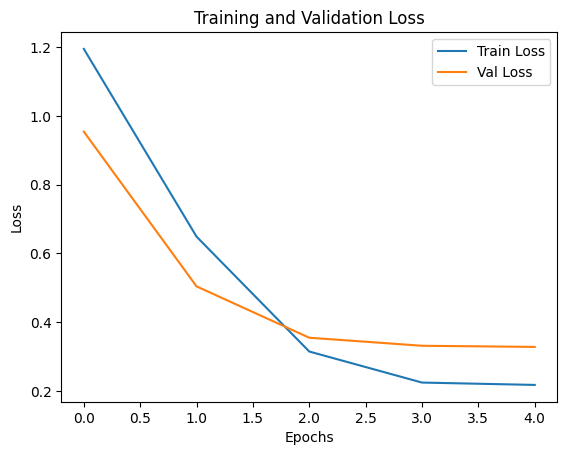

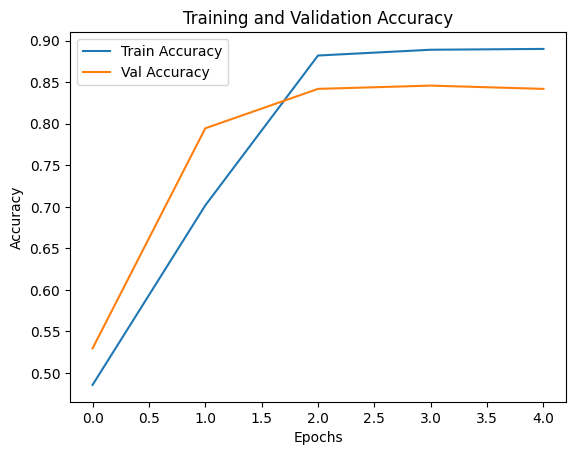

In [ ]:
def train_model(model, train_loader, val_loader, epochs=5):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                running_val_loss += loss.item()

                # Store all predictions
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        f1_scores = f1_score(all_labels, all_preds, average=None)
        conf_matrix = confusion_matrix(all_labels, all_preds)
        f1_score_avg = f1_score(all_labels, all_preds, average='weighted')

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"F1 Scores for each class: {f1_scores}")

        print("F1 score", f1_score_avg)
        print('-' * 50)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total training time: {elapsed_time:.2f} seconds")

    # Save the model
    # torch.save(model.state_dict(), "/content/drive/MyDrive/Parspec/model.pth")
    # torch.save(model.state_dict(), "/content/drive/MyDrive/Parspec/model_correct_split.pth")
    # torch.save(model.state_dict(), "/content/drive/MyDrive/Parspec/model_dropout.pth")
    # torch.save(model.state_dict(), "/content/drive/MyDrive/Parspec/model_data_dropout.pth")
    # torch.save(model.state_dict(), "/content/drive/MyDrive/Parspec/model_data.pth") # model to use


    # Plot losses and accuracies
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


# Input filepath of train data
filepath = '/content/drive/MyDrive/Parspec/train_data/train_data_df6.csv'
dataset = PDFTextDataset(filepath)
train_loader, val_loader = dataset.get_dataloader()

model = TextClassifier(embedding_size, hidden_dim, output_dim)

train_model(model, train_loader, val_loader)

## Evaluation function

### Preparing Test Data

                                      datasheet_link target_col
0  https://lumenart.com/images/alume/awl-01_specs...   lighting
1  https://lumenart.com/images/fabric/rdc/rdc_spe...   lighting
2  https://lumenart.com/images/fabric/cyp/cyp_spe...   lighting
3  https://lumenart.com/images/designer/wlp_specs...   lighting
4  https://lumenart.com/images/designer/wcp/wcp-s...   lighting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   datasheet_link  400 non-null    object
 1   target_col      400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB
None
--------------------------------------------------
Shape: (256, 2)
--------------------------------------------------


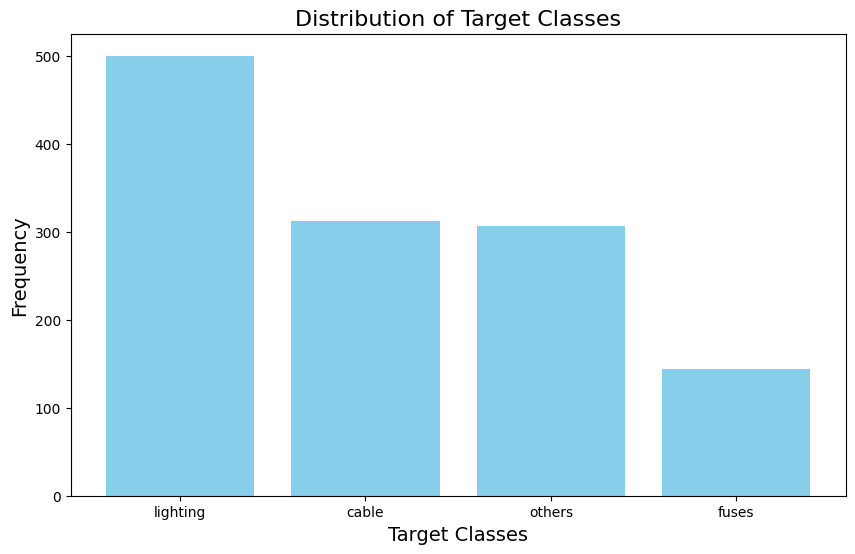

In [ ]:
# Preprocess the data
test_filepath = '/content/drive/MyDrive/Parspec/test_data/mle-1-assign-dataset - test_data.csv'
test_data_processor = DataPreprocess(test_filepath)
test_data_processor.display()
test_preprocessed_data = test_data_processor.processed()
print('-' * 50)
print("Shape:", test_preprocessed_data.shape)
print('-' * 50)

# Distribution of target column
target_class = preprocessed_data['target_col'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(target_class.index, target_class.values, color='skyblue')

plt.title('Distribution of Target Classes', fontsize=16)
plt.xlabel('Target Classes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


In [ ]:
# Extract text from data
extractor = ExtractData()
df1 = extractor.extract_text(test_preprocessed_data[:200])
df2 = extractor.extract_text(test_preprocessed_data[200:])
df1.to_csv('/content/drive/MyDrive/Parspec/test_data/df1.csv', escapechar='\\', index=False)
df2.to_csv('/content/drive/MyDrive/Parspec/test_data/df2.csv', escapechar='\\', index=False)

<ipython-input-10-1c5041cc5316>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = ""
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Processing rows:  22%|██▏       | 44/200 [04:16<34:57, 13.45s/it]

https://www.nerinorthamerica.com/supporto/DownloadNeri.ashx?f=PU313LUS.pdf&LN=en-US
Error extracting text from PDF: code=7: no objects found


Processing rows:  22%|██▎       | 45/200 [04:24<30:13, 11.70s/it]

https://www.nerinorthamerica.com/supporto/DownloadNeri.ashx?f=PU313LUS.pdf&LN=en-US
Error extracting text from PDF: code=7: no objects found


Processing rows:  23%|██▎       | 46/200 [04:25<22:23,  8.73s/it]

https://www.nerinorthamerica.com/supporto/DownloadNeri.ashx?f=PU313LUS.pdf&LN=en-US
Error extracting text from PDF: code=7: no objects found


Processing rows:  24%|██▍       | 49/200 [04:36<12:40,  5.03s/it]

https://www.nerinorthamerica.com/supporto/DownloadNeri.ashx?f=PU313LUS.pdf&LN=en-US
Error extracting text from PDF: code=7: no objects found


Processing rows:  26%|██▋       | 53/200 [04:46<06:48,  2.78s/it]

https://www.nerinorthamerica.com/supporto/DownloadNeri.ashx?f=PU313LUS.pdf&LN=en-US
Error extracting text from PDF: code=7: no objects found


Processing rows:  62%|██████▏   | 123/200 [08:34<02:40,  2.09s/it]

https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf
Error extracting text from PDF: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf
Error extracting text from PDF: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)


Processing rows:  62%|██████▎   | 125/200 [09:11<11:12,  8.97s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.
Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  64%|██████▎   | 127/200 [09:13<06:03,  4.98s/it]

https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf
Error extracting text from PDF: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf
Error extracting text from PDF: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)


Processing rows:  66%|██████▌   | 131/200 [09:54<07:10,  6.24s/it]

https://publish.sanyodenki.com/San_Ace_PWM_Controller_E/book/
Error extracting text from PDF: code=7: no objects found
https://publish.sanyodenki.com/San_Ace_PWM_Controller_E/book/
Error extracting text from PDF: code=7: no objects found
https://publish.sanyodenki.com/San_Ace_PWM_Controller_E/book/
Error extracting text from PDF: code=7: no objects found
https://publish.sanyodenki.com/San_Ace_PWM_Controller_E/book/
Error extracting text from PDF: code=7: no objects found
https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf
Error extracting text from PDF: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=20)
https://publish.sanyodenki.com/San_Ace_PWM_Controller_E/book/
Error extracting text from PDF: code=7: no objects found


Processing rows:  66%|██████▋   | 133/200 [10:19<09:32,  8.54s/it]

https://www.hammfg.com/electronics/small-case/plastic/rp-rit
Error extracting text from PDF: code=7: no objects found


Processing rows:  67%|██████▋   | 134/200 [10:22<07:19,  6.65s/it]

https://www.hammfg.com/electronics/small-case/plastic/rp-rit
Error extracting text from PDF: code=7: no objects found


Processing rows:  68%|██████▊   | 135/200 [10:23<05:30,  5.09s/it]

https://www.hammfg.com/electronics/small-case/plastic/rp-rit
Error extracting text from PDF: code=7: no objects found
https://www.hammfg.com/electronics/small-case/plastic/rp-rit
Error extracting text from PDF: code=7: no objects found
https://www.hammfg.com/electronics/small-case/plastic/rp-rit
Error extracting text from PDF: code=7: no objects found


Processing rows:  70%|██████▉   | 139/200 [10:58<05:55,  5.83s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.
Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  71%|███████   | 142/200 [10:59<02:12,  2.29s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.
Error extracting text from image: cannot identify image file 'images/page_0_img_1.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_2.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_3.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_4.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_5.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_6.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_7.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_8.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_9.jb2'
Error extracting text from image: cannot identify image file 'images/page_0_img_10.jb2'
Erro

Processing rows:  72%|███████▏  | 143/200 [11:00<01:50,  1.93s/it]

https://publish.sanyodenki.com/San_Ace_E/book/#target/page_no=603
Error extracting text from PDF: code=7: no objects found


Processing rows:  72%|███████▏  | 144/200 [11:02<01:52,  2.00s/it]

https://publish.sanyodenki.com/San_Ace_E/book/#target/page_no=603
Error extracting text from PDF: code=7: no objects found
https://publish.sanyodenki.com/San_Ace_E/book/#target/page_no=603
Error extracting text from PDF: code=7: no objects found
https://publish.sanyodenki.com/San_Ace_E/book/#target/page_no=603
Error extracting text from PDF: code=7: no objects found
https://publish.sanyodenki.com/San_Ace_E/book/#target/page_no=603
Error extracting text from PDF: code=7: no objects found


Processing rows:  82%|████████▏ | 164/200 [12:11<01:31,  2.55s/it]

https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9058ac/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9058ac/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9058ac/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9058ac/
Error extracting text from PDF: code=7: no objects found


Processing rows:  84%|████████▍ | 168/200 [12:40<02:22,  4.45s/it]

https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9058ac/

Error extracting text from PDF: code=7: no objects found

Processing rows:  86%|████████▌ | 172/200 [12:48<01:19,  2.83s/it]

https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9213/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9213/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9213/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9213/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9213/
Error extracting text from PDF: code=7: no objects found


Processing rows:  92%|█████████▎| 185/200 [13:43<00:18,  1.24s/it]

https://prysmian-group.dcatalog.com/v/Electronics/#page=162
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9316/
Error extracting text from PDF: code=7: no objects found
https://prysmian-group.dcatalog.com/v/Electronics/#page=162
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9316/
Error extracting text from PDF: code=7: no objects found
https://prysmian-group.dcatalog.com/v/Electronics/#page=162
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9316/
Error extracting text from PDF: code=7: no objects found
https://prysmian-group.dcatalog.com/v/Electronics/#page=162
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9316/
Error extracting text from PDF: code=7: no object

Processing rows:  95%|█████████▌| 190/200 [14:23<00:36,  3.63s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  98%|█████████▊| 195/200 [14:51<00:40,  8.17s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  98%|█████████▊| 197/200 [14:56<00:15,  5.32s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows: 100%|██████████| 200/200 [15:02<00:00,  4.51s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

<ipython-input-10-1c5041cc5316>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = ""
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Processing rows:  12%|█▎        | 7/56 [00:08<01:05,  1.34s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  36%|███▌      | 20/56 [00:21<00:44,  1.25s/it]

Error extracting text from image: tesseract is not installed or it's not in your PATH. See README file for more information.


Processing rows:  38%|███▊      | 21/56 [00:24<00:56,  1.63s/it]

https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9217/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9217/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9217/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9217/
Error extracting text from PDF: code=7: no objects found
https://www.alphawire.com/products/cable/alpha-essentials/coaxial-cable/9217/
Error extracting text from PDF: code=7: no objects found


Processing rows: 100%|██████████| 56/56 [01:41<00:00,  1.82s/it]


In [ ]:
# merge
df1 = pd.read_csv("/content/drive/MyDrive/Parspec/test_data/df1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Parspec/test_data/df2.csv")

test_df = pd.concat([df1, df2], ignore_index=True)
test_df.dropna(inplace=True)
print(test_df.shape)
test_df.to_csv('/content/drive/MyDrive/Parspec/test_data/test_data.csv', escapechar='\\', index=False)

(204, 3)


In [ ]:
# dataclass
class PDFTextDataset(Dataset):
    def __init__(self, filepath):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.df = pd.read_csv(filepath)

        self.df['content'] = self.df['content'].fillna('')
        self.df['embedding'] = self.df['content'].apply(lambda x: self.model.encode(x))

        embeddings = self.df['embedding'].tolist()
        embedding_size = len(embeddings[0]) if embeddings else 0
        self.X = torch.tensor(embeddings, dtype=torch.float32)

        label_encoder = LabelEncoder()
        self.df['target_col'] = label_encoder.fit_transform(self.df['target_col'])
        self.y = torch.tensor(self.df['target_col'].values, dtype=torch.long)

        self.test_data = TensorDataset(self.X, self.y)

        save_path = "/content/drive/MyDrive/Parspec/test_data/test_embedding.pkl"
        with open(save_path, 'wb') as f:
            pickle.dump(embeddings, f)

    def get_test_dataloader(self, batch_size=32):
        test_loader = DataLoader(self.test_data, batch_size=batch_size, shuffle=False)
        return test_loader


In [ ]:
# model class
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return self.softmax(x)


### Test

In [ ]:
# Model parameters
embedding_size = 384  # Size of the embedding vector from SentenceTransformer
hidden_dim = 128
output_dim = 4  # Number of classes

model = TextClassifier(embedding_size, hidden_dim, output_dim)
print(model) # Check model architecture

TextClassifier(
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
def evaluate_model(model, test_loader):

    model.load_state_dict(torch.load("/content/drive/MyDrive/Parspec/model_data.pth"))

    start_time = time.time()
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    end_time = time.time()
    evaluation_time = end_time - start_time

    all_preds = np.array(all_preds)  # convert to np array
    all_labels = np.array(all_labels)

    # Evaluation metric
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test F1 Score: {f1:.4f}")
    print()

    for i, f1 in enumerate(f1_per_class):
        print(f"F1 Score for class {i}: {f1:.4f}")

    print("\nConfusion Matrix:")
    print(conf_matrix)

    print(f"\nTime taken to evaluate the test data: {evaluation_time:.4f} seconds")

filepath = '/content/drive/MyDrive/Parspec/test_data/test_data.csv'
dataset = PDFTextDataset(filepath)
test_loader = dataset.get_test_dataloader()

model = TextClassifier(embedding_size, hidden_dim, output_dim)
evaluate_model(model, test_loader)

# ML model

## Data class

**Description:**
1. Reads a CSV file as input
2. Converts the content column into embeddings using the SentenceTransformer model and encodes label


In [ ]:
# Initialize the dataset
def MLdataset(filepath):
        model = SentenceTransformer('all-MiniLM-L6-v2')
        df = pd.read_csv(filepath)

        df['content'] = df['content'].fillna('')
        df['embedding'] = df['content'].apply(lambda x: model.encode(x))

        embeddings = df['embedding'].tolist()
        X_test_np = np.array(embeddings)

        label_encoder = LabelEncoder()
        df['target_col'] = label_encoder.fit_transform(['target_col'])

        y = df['target_col'].values

        with open('/content/drive/MyDrive/Parspec/train_data/embeddings.pkl', 'wb') as f:
            pickle.dump((X_test_np, y), f)

        return X_test_np, y

# class PDFTextDataset(Dataset):
#     def __init__(self, filepath, save_embeddings=False):
#         self.model = SentenceTransformer('all-MiniLM-L6-v2')
#         self.df = pd.read_csv(filepath)

#         self.df['content'] = self.df['content'].fillna('')
#         self.df['embedding'] = self.df['content'].apply(lambda x: self.model.encode(x))

#         embeddings = self.df['embedding'].tolist()
#         # embedding_size = len(embeddings[0]) if embeddings else 0
#         # self.X = torch.tensor(embeddings, dtype=torch.float32)

#         label_encoder = LabelEncoder()
#         self.df['target_col'] = label_encoder.fit_transform(self.df['target_col'])
#         self.y = torch.tensor(self.df['target_col'].values, dtype=torch.long)

#         # Save the embeddings and labels if required
#         if save_embeddings:
#             with open('/content/drive/MyDrive/Parspec/train_data/embeddings.pkl', 'wb') as f:
#                 pickle.dump((embeddings, self.df['target_col'].values), f)


# dataset = PDFTextDataset(filepath='/content/drive/MyDrive/Parspec/train_data/train_data_df6.csv', save_embeddings=True)


## Training loop (XGBoost)

In [ ]:
# Load the embeddings
# with open('/content/drive/MyDrive/Parspec/train_data/embeddings.pkl', 'rb') as f:
#     X, y = pickle.load(f)

X, y = MLdataset('/content/drive/MyDrive/Parspec/train_data/train_data_df6.csv')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

start_time = time.time()
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)

end_time = time.time()
evaluation_time = end_time - start_time

# Evaluation Metric
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
f1_per_class = f1_score(y_val, y_pred, average=None)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print()

print("F1 Score per class:")
for i, f1 in enumerate(f1_per_class):
    print(f"Class {i}: {f1:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

print(f"\nTime taken to evaluate the train data: {evaluation_time:.4f} seconds")
# Save the model
xgb_model.save_model('/content/drive/MyDrive/Parspec/train_data/xgb_model.json')


Accuracy: 0.8379
F1 Score: 0.8374

F1 Score per class:
Class 0: 0.8440
Class 1: 0.8679
Class 2: 0.8403
Class 3: 0.8113

Confusion Matrix:
[[ 46   1  15   1]
 [  0  23   5   1]
 [  0   0 100   0]
 [  0   0  18  43]]

Time taken to evaluate the train data: 5.1634 seconds


## Evaluation

### Preparing test data

In [ ]:
def MLdataset(filepath):
        model = SentenceTransformer('all-MiniLM-L6-v2')
        df = pd.read_csv(filepath)

        df['content'] = df['content'].fillna('')
        df['embedding'] = df['content'].apply(lambda x: model.encode(x))

        embeddings = df['embedding'].tolist()
        X_test_np = np.array(embeddings)

        label_encoder = LabelEncoder()
        df['target_col'] = label_encoder.fit_transform(['target_col'])

        y = df['target_col'].values

        with open('/content/drive/MyDrive/Parspec/train_data/embeddings.pkl', 'wb') as f:
            pickle.dump((X_test_np, y), f)

        return X_test_np, y

# class PDFTextDataset(Dataset):
#     def __init__(self, filepath):
#         self.model = SentenceTransformer('all-MiniLM-L6-v2')
#         self.df = pd.read_csv(filepath)

#         self.df['content'] = self.df['content'].fillna('')
#         self.df['embedding'] = self.df['content'].apply(lambda x: self.model.encode(x))

#         embeddings = self.df['embedding'].tolist()
#         embedding_size = len(embeddings[0]) if embeddings else 0
#         self.X = torch.tensor(embeddings, dtype=torch.float32)

#         label_encoder = LabelEncoder()
#         self.df['target_col'] = label_encoder.fit_transform(self.df['target_col'])

#         self.test_data = TensorDataset(self.X, self.y)

#         save_path = "/content/drive/MyDrive/Parspec/test_data/test_embedding.pkl"
#         with open(save_path, 'wb') as f:
#             pickle.dump((embeddings, self.df['target_col'].values), f)


# Load the test data
# filepath = '/content/drive/MyDrive/Parspec/test_data/test_data.csv'
# dataset = PDFTextDataset(filepath)
# test_loader = dataset.get_test_dataloader()


In [ ]:
# Test data
# with open('/content/drive/MyDrive/Parspec/test_data/test_embedding.pkl', 'rb') as f:
#     X_test, y_test = pickle.load(f)

# X_test_np = np.array(X_test)

X_test, y_test = MLdataset('/content/drive/MyDrive/Parspec/test_data/test_data.csv')

### Test

In [ ]:
# Evaluation
xgb_model = xgb.XGBClassifier()
xgb_model.load_model('/content/drive/MyDrive/Parspec/train_data/xgb_model.json')

start_time = time.time()

y_pred = xgb_model.predict(X_test)

end_time = time.time()
evaluation_time = end_time - start_time

# Evaluation Metric
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
f1_per_class = f1_score(y_test, y_pred, average=None)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

print()
print("F1 Score per class:")

for i, f1 in enumerate(f1_per_class):
    print(f"Class {i}: {f1:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

print(f"\nTime taken to evaluate the test data: {evaluation_time:.4f} seconds")

Test Accuracy: 0.9412
Test F1 Score: 0.9366

F1 Score per class:
Class 0: 0.9630
Class 1: 1.0000
Class 2: 0.9494
Class 3: 0.7727

Confusion Matrix:
[[78  0  0  0]
 [ 0 22  0  0]
 [ 2  0 75  0]
 [ 4  0  6 17]]

Time taken to evaluate the test data: 0.0026 seconds
